In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from scipy.interpolate import UnivariateSpline
import sys
import os
from scipy import optimize
from scipy import constants
import scipy as scp
from scipy.signal import butter,filtfilt

import shelve as shv

import json
from pandas import Series
from pandas import Timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy import stats 
import h5py
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["legend.fancybox"] = False
SMALL_SIZE = 6
MEDIUM_SIZE = 7
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



from numba import jit, njit, prange


from datapipeline import loadData, getTriggerSortedData

eCharge= 1.602e-19

cm = 1/2.54


dataPath = ''
measID = '4IMCT3'


measPath = measID
statePath = measPath+'/measState.txt'

with open(statePath) as json_file:
    measDict = json.load(json_file)
 

print(measDict)

outPath = os.path.join('FigureOutputV2',os.path.basename(os.path.normpath(dataPath)),measID)

print(outPath)

isExist = os.path.exists(outPath)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(outPath)
   print("The new directory is created!")

{'nEnergy': 40, 'mdepth': '10M', 'tscale': 0.1, 'travelDistance': 3.09e-06, 'centerPos': 0.004447781025, 'Velocity': 5150, 'CEP Scan resolution': 6.4375e-08, 'CH1 Scale': 0.05, 'CH2 Scale': 0.2, 'CH3 Scale': 0.5, 'max Power': 4.379722, 'max Energy Post': 4.287388}
FigureOutputV2/./4IMCT3


In [2]:

dataCH1, dataCH2, dataCH3 = loadData(measPath)

dataCH1= (dataCH1/30)*measDict['CH1 Scale']
dataCH2 = (dataCH2/30)*measDict['CH2 Scale']


print('Data loaded ')

n,m = dataCH1.shape
print(n,m)

Data loaded
Data loaded 
41 10000000


In [3]:
#@jit(nopython=True)
def sortData(data1,data2, peaks, boxlen, boxstart, boxstart2):
    # Sort the data by the trigger
    # trigger is already the indices of the trigger
    a = data1.shape
    peakShape = peaks.shape
    print(f" Data shape inner FCN: {a}")
    
    dataTriggsorted = np.zeros((a[0],peakShape[1],boxlen+np.abs(boxstart)))
    dataTriggsorted2 = np.zeros((a[0],peakShape[1],boxlen+np.abs(boxstart2)))
    print(f" Data shape inner FCN: {dataTriggsorted.shape}")

    for l in np.arange(a[0],dtype=np.int8):
        print(f"Sorting data for channel {l}")
        
        for i,j in enumerate(peaks[l,:]):
            #print(f"index {i}, peak ID {j}")
            
            dataTriggsorted[l,i,:] = data1[l,int(j+boxstart):int(j+boxlen)]
            dataTriggsorted2[l,i,:] = data2[l,int(j+boxstart):int(j+boxlen)]

    return dataTriggsorted,dataTriggsorted2




def trigSortedData(data1,data2, trigger, boxlen, boxstart, boxstart2):
    # Get the data sorted by the trigger
    # data is the data vector - expected to be a 1D vector and in units of V
    # boxlen is the length of the box in samples
    # trigger is the trigger position - expected to be a 1D vector
    # params is a dictionary with the following keys:
    #   'boxlen' - the length of the box in samples
    #   'boxStart' - the start of the box in samples relative to the trigger
    #   'boxStop' - the stop of the box in samples
    #   'boxStart2' - the start of the box in samples relative to the trigger
    #   'boxStop2' - the stop of the box in samples
    a = data1.shape
    print(f" Data shape Outer FCN: {a}")
    deltaW=np.gradient(trigger,axis=1)

    for i in range(a[0]):
        peaksTemp, _ = signal.find_peaks(-(deltaW[i,:]),distance=180,height=20)
        peaksTemp = peaksTemp[1:-2]
        if i==0:
            peaks=np.zeros((a[0],len(peaksTemp)))
        
        if len(peaksTemp)<len(peaks[0,:]):
            peaksTemp=np.append(peaksTemp,np.ones(len(peaks[0,:])-len(peaksTemp))*peaksTemp[-1])
        if len(peaksTemp)>len(peaks[0,:]):
            peaksTemp=peaksTemp[0:len(peaks[0,:])]
            
        peaks[i,:] = peaksTemp

    print("Peaks found. Sorting data")

    print(f" Peak shape: {peaks.shape}")

    return sortData(data1,data2, peaks, boxlen, boxstart, boxstart2)

In [4]:
lenbox = 200
print(n,m)
params = {'boxlen':lenbox,'boxStart':-60,'boxStop':100,'boxStart2':-60,'boxStop2':100}

a,b = trigSortedData(dataCH1,dataCH2, dataCH3,params['boxlen'],params['boxStart'],params['boxStart2'])

del(dataCH1)
del(dataCH2)
del(dataCH3)

41 10000000
 Data shape Outer FCN: (41, 10000000)
Peaks found. Sorting data
 Peak shape: (41, 50003)
 Data shape inner FCN: (41, 10000000)
 Data shape inner FCN: (41, 50003, 260)
Sorting data for channel 0
Sorting data for channel 1
Sorting data for channel 2
Sorting data for channel 3
Sorting data for channel 4
Sorting data for channel 5
Sorting data for channel 6
Sorting data for channel 7
Sorting data for channel 8
Sorting data for channel 9
Sorting data for channel 10
Sorting data for channel 11
Sorting data for channel 12
Sorting data for channel 13
Sorting data for channel 14
Sorting data for channel 15
Sorting data for channel 16
Sorting data for channel 17
Sorting data for channel 18
Sorting data for channel 19
Sorting data for channel 20
Sorting data for channel 21
Sorting data for channel 22
Sorting data for channel 23
Sorting data for channel 24
Sorting data for channel 25
Sorting data for channel 26
Sorting data for channel 27
Sorting data for channel 28
Sorting data for ch

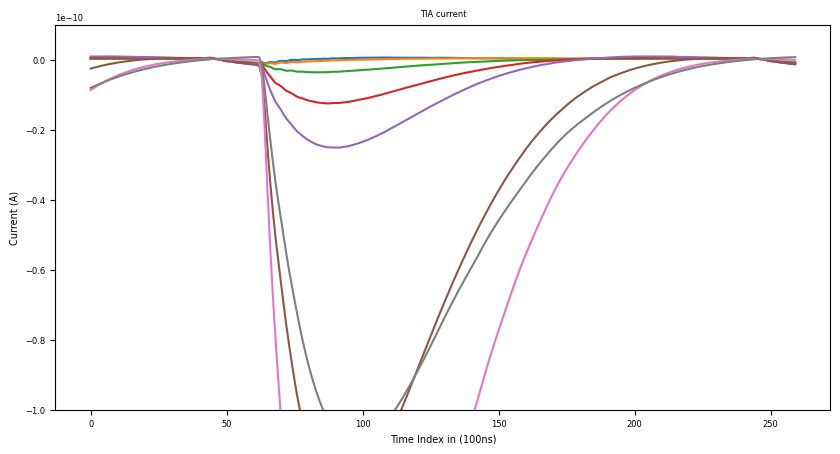

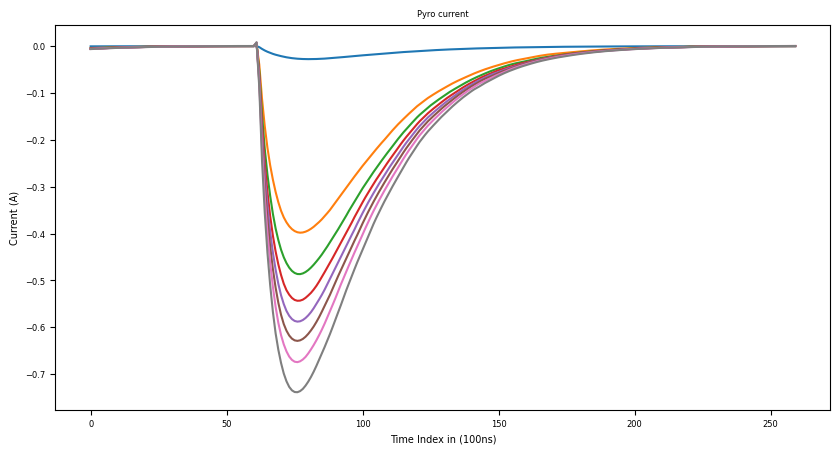

In [5]:
listID = np.arange(0,40,5)


for i in listID:
    plt.plot((np.mean(a[i,:,:],axis=0)-np.mean(np.mean(a[i,:,:],axis=0)[-30:-1]))/1e9)
plt.xlabel('Time Index in (100ns)')
plt.ylabel('Current (A)')
plt.title('TIA current')
plt.ylim([-0.1e-9,0.1e-10])
plt.savefig(os.path.join(outPath,'TIAcurrentPulseShape.pdf'))
plt.show()

for i in listID:
    plt.plot(np.mean(b[i,:,:],axis=0)-np.mean(np.mean(b[i,:,:],axis=0)[-30:-1]))
plt.xlabel('Time Index in (100ns)')
plt.ylabel('Current (A)')
plt.title('Pyro current')
plt.savefig(os.path.join(outPath,'PyrocurrentPulseShape.pdf'))

plt.show()


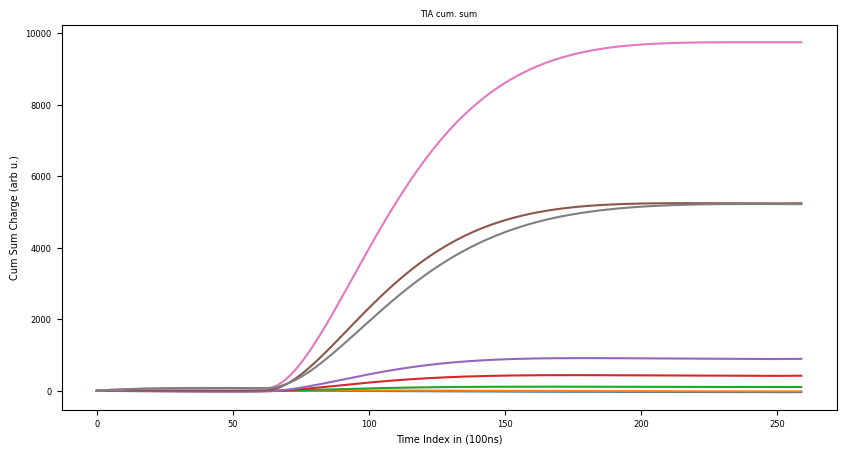

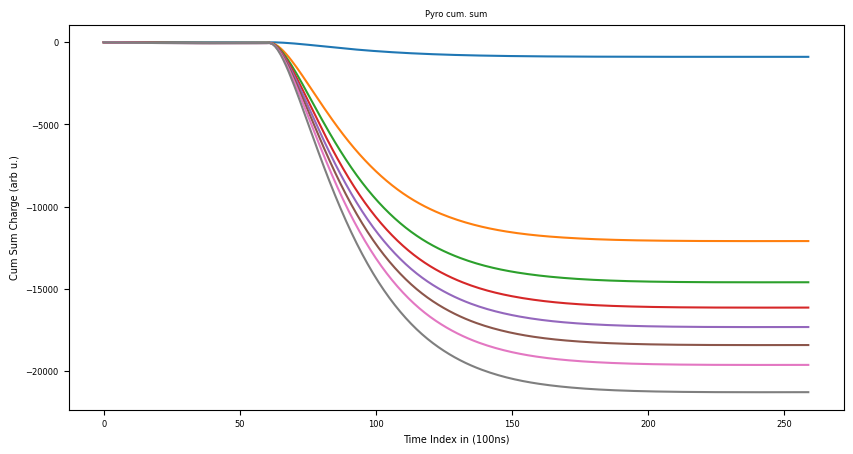

In [6]:
# Integrating
# 1. TIA current

for i in listID:
    #print(i)
    plt.plot(np.cumsum((-np.mean(a[i,:,:],axis=0)+np.mean(np.mean(a[i,:,:],axis=0)[-30:-1]))/1e9,axis=0)*1e-7/eCharge)
plt.xlabel('Time Index in (100ns)')
plt.ylabel('Cum Sum Charge (arb u.)')
plt.title('TIA cum. sum')
#plt.ylim([86000,88000])
#plt.xlim([200,260])
plt.savefig(os.path.join(outPath,'TIAcumSum.pdf'))
plt.show()


# 2. Pyro current

for i in listID:
    #print(i)
    plt.plot(np.cumsum((np.mean(b[i,:,:],axis=0)-np.mean(np.mean(b[i,:,:],axis=0)[-30:-1]))/1e9,axis=0)*1e-7/eCharge)
#plt.ylim([0,50])
plt.xlim()
plt.xlabel('Time Index in (100ns)')
plt.ylabel('Cum Sum Charge (arb u.)')
plt.title('Pyro cum. sum')
plt.savefig(os.path.join(outPath,'PyrocumSum.pdf'))
plt.show()



41 50003 260
Scaling the charge yield by a factor of 1 for the first 27 events and 2 for the next 2 events and 4 for the next 2 events and 8 for the rest of the events


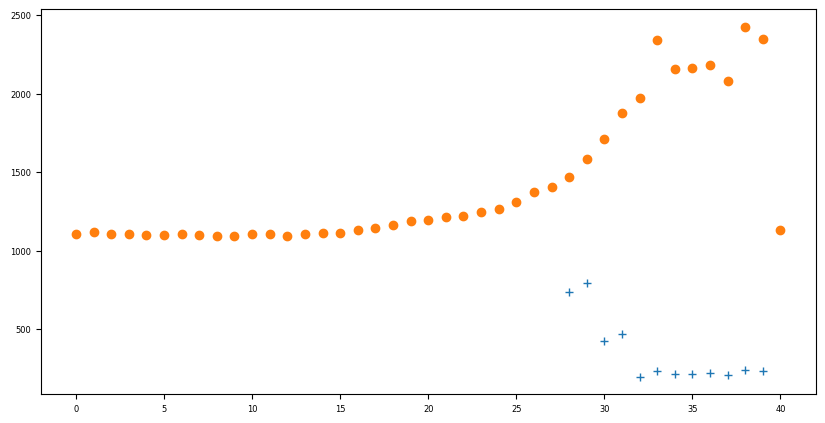

In [7]:
# Reading out the charge yield
m,k,l = a.shape
print (m,k,l)

chargeYield = np.zeros((m,k))

for i in range(m):
      temp = np.cumsum(a[i,:,:]/1e9 - np.mean(a[i,:,-30:-1],axis=1)[:,None]/1e9,axis=1)*1e-7/eCharge
      chargeYield[i,:] = temp[:,250]-temp[:,60]

plt.plot(np.std(chargeYield[:,35000:-1],axis=1),marker='+',linestyle='None')


# The measurements were scaled manually on the oscilloscope and these correction factors account for it. This can also be verified by looking at the baseline TIA noise as this is virtually constant across all measurements

scalingVector = np.ones(m)
scalingVector[32:-1]= 10
scalingVector[30:32]= 4
scalingVector[28:30]= 2
chargeYield = chargeYield*scalingVector[:,None]
print('Scaling the charge yield by a factor of 1 for the first 27 events and 2 for the next 2 events and 4 for the next 2 events and 8 for the rest of the events')
      
plt.plot(np.std(chargeYield[:,35000:-1],axis=1),marker='o',linestyle='None')
plt.show()

pulseEnergy = np.zeros((m,k))

for i in range(m):
      temp = np.cumsum(-b[i,:,:]/1e9 - np.mean(-b[i,:,-30:-1],axis=1)[:,None]/1e9,axis=1)*1e-7/eCharge
      pulseEnergy[i,:] = temp[:,250]-temp[:,60]


# There was an issue with the data, so I had to scale the first 40 events by a factor of 10
if measID == '4CMCT0':
      chargeYield[0:-1,:] *= 10


In [8]:
print(f"Technical Noise Charge yield: {np.std(chargeYield[-1,:])} (e)")
print(f"Technical Noise Charge yield: {np.std(chargeYield[0,:])} (e)")

print(f"Technical Noise Pulse Energy: {np.std(pulseEnergy[-1,:])} (e)")

cepNoisefloor = np.std(chargeYield[-1,:])

Technical Noise Charge yield: 1140.4525192625804 (e)
Technical Noise Charge yield: 1106.3659756768861 (e)
Technical Noise Pulse Energy: 311.84442467102417 (e)


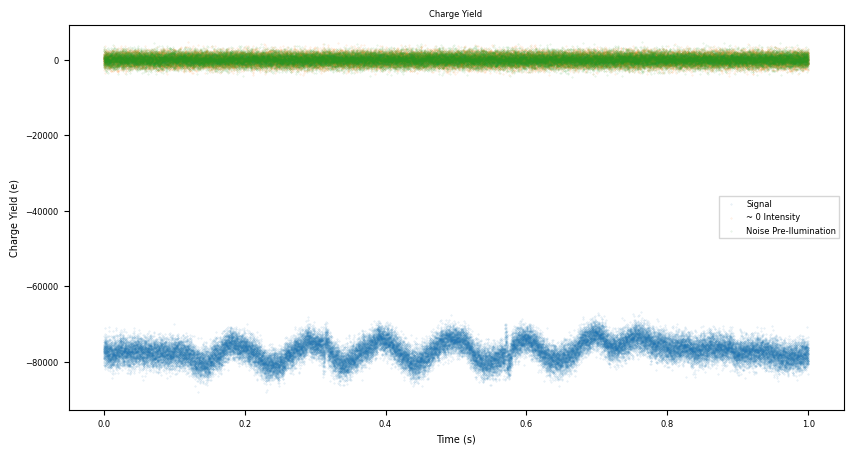

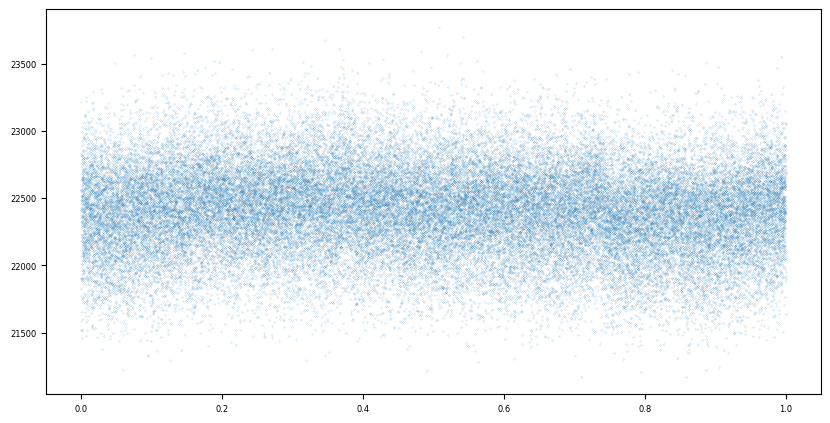

In [9]:


time = np.arange(0,k)*20e-6
id =38

plt.scatter(time,chargeYield[id,:],s=0.1,alpha=0.2)
plt.scatter(time,chargeYield[0,:],s=0.1,alpha=0.2)
plt.scatter(time,chargeYield[-1,:],s=0.1,alpha=0.2)

plt.xlabel('Time (s)')
plt.ylabel('Charge Yield (e)')
plt.title('Charge Yield')
plt.legend(['Signal','~ 0 Intensity'  ,'Noise Pre-Ilumination'])
plt.savefig(os.path.join(outPath,'ChargeYield.pdf'))
plt.show()

plt.scatter(time,pulseEnergy[id,:],s=0.01)
plt.show()




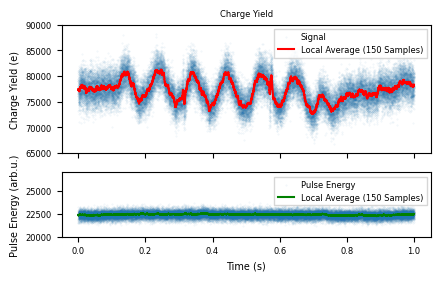

In [10]:


# Plotting the charge yield
from scipy.ndimage import uniform_filter1d
avgCount = 150

testOut = uniform_filter1d(chargeYield[id,:], size=avgCount)
testOut2 = uniform_filter1d(pulseEnergy[id,:], size=avgCount)



fig,ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [2,1]},figsize=(cm*12.1,cm*7),sharex=True)

ax[0].scatter(time,-chargeYield[id,:],s=0.1,alpha=0.1,rasterized=True)
ax[0].plot(time,-testOut,color='red',alpha=1)
ax[0].set_ylim([65000,90000])
ax[0].set_ylabel('Charge Yield (e)')
ax[0].set_title('Charge Yield')
ax[0].legend(['Signal',f"Local Average ({avgCount} Samples)",'Pulse Energy'])

ax[1].scatter(time,pulseEnergy[id,:],s=0.1,alpha=0.1,rasterized=True)
ax[1].plot(time,testOut2,color='green',alpha=1)
ax[1].set_ylabel('Pulse Energy (arb.u.)')
ax[1].set_ylim([20000,27000])

ax[1].set_xlabel('Time (s)')
ax[1].legend(['Pulse Energy',f"Local Average ({avgCount} Samples)"])
fig.savefig(os.path.join(outPath,f"ChargeYieldVsEnergy{id}.pdf"),dpi=600)
fig.savefig(os.path.join(outPath,f"ChargeYieldVsEnergy{id}.png"),dpi=300)

plt.show()

Number of peaks: 5
Peak Positions: [0.12688 0.31406 0.57146 0.77388 0.92568]
Peak Distance: [0.18718 0.2574  0.20242 0.1518 ]


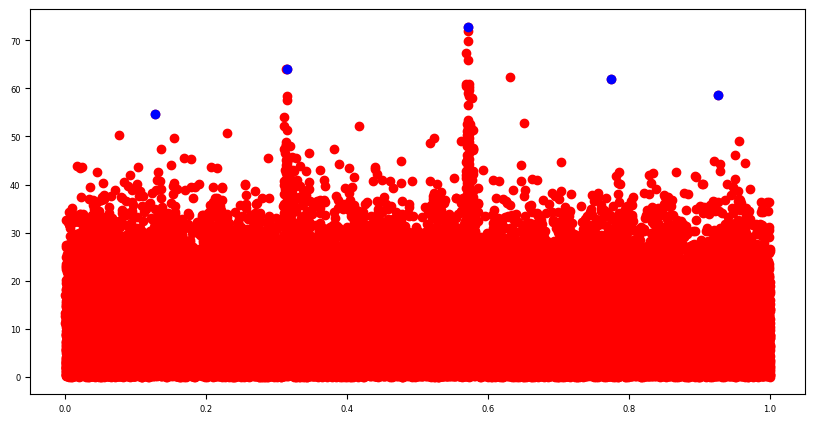

In [11]:
plt.scatter(time,np.abs(np.gradient(-testOut)),color='red',alpha=1)

peaks,__  =signal.find_peaks(np.abs(np.gradient(-testOut)),height=40,distance=7000)
plt.scatter(time[peaks],np.abs(np.gradient(-testOut))[peaks],color='blue',alpha=1)

print(f"Number of peaks: {len(peaks)}")
print(f"Peak Positions: {time[peaks]}")
print(f"Peak Distance: {np.diff(time[peaks])}")


/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/1903993588.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,25e3])


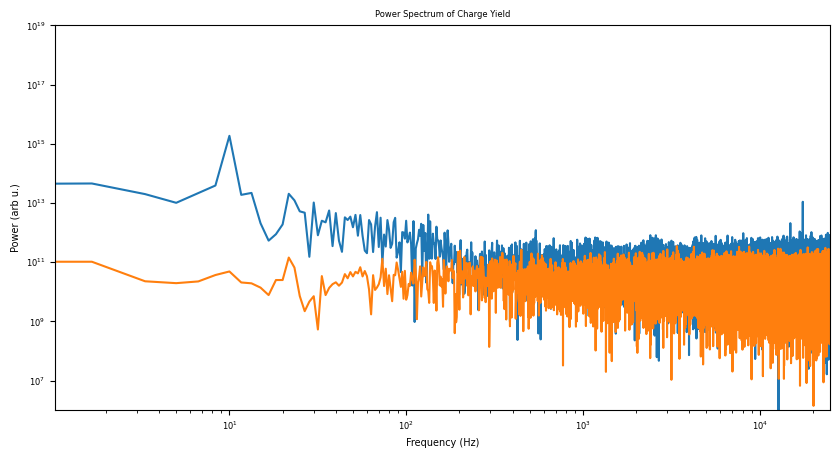

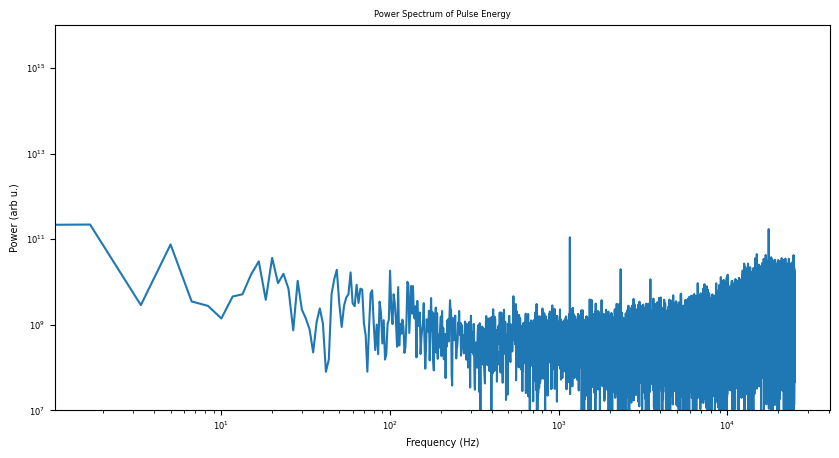

In [12]:

freq = np.fft.fftshift(np.fft.fftfreq(len(chargeYield[0,5000:35000]),20e-6))

spectrumCharge = np.fft.fftshift(np.fft.fft(chargeYield[id,5000:35000]-np.mean(chargeYield[id,5000:35000])))

spectrumNoise = np.fft.fftshift(np.fft.fft(chargeYield[0,5000:35000]-np.mean(chargeYield[40,5000:35000])))

spectrumEnergy = np.fft.fftshift(np.fft.fft(pulseEnergy[id,5000:35000]-np.mean(pulseEnergy[id,5000:35000])))


plt.loglog(freq,np.abs(spectrumCharge[:])**2)

plt.loglog(freq,np.abs(spectrumNoise[:])**2)
plt.ylim([10e5,10e18])
plt.xlim([0,25e3])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (arb u.)')
plt.title('Power Spectrum of Charge Yield')
plt.savefig(os.path.join(outPath,f"SpectrumChargeID{id}.pdf"))
plt.show()

plt.loglog(freq,np.abs(spectrumEnergy[:])**2)
plt.ylim([10e6,10e15])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (arb u.)')
plt.title('Power Spectrum of Pulse Energy')
plt.savefig(os.path.join(outPath,f"SpectrumEnergyID{id}.pdf"))
plt.show()

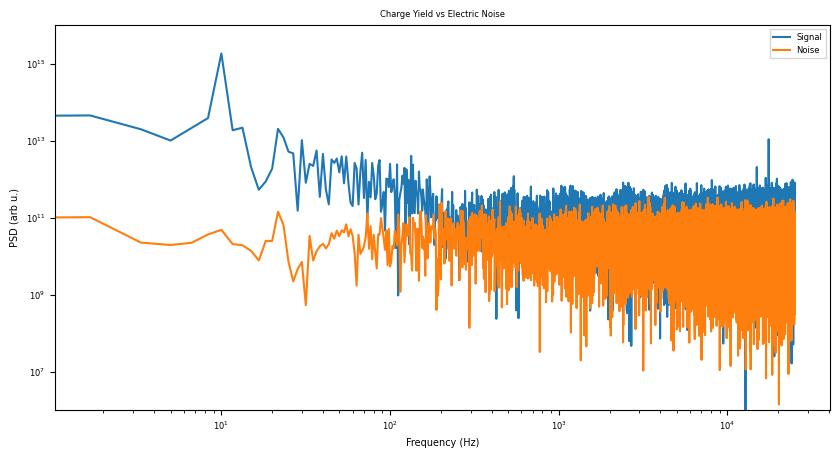

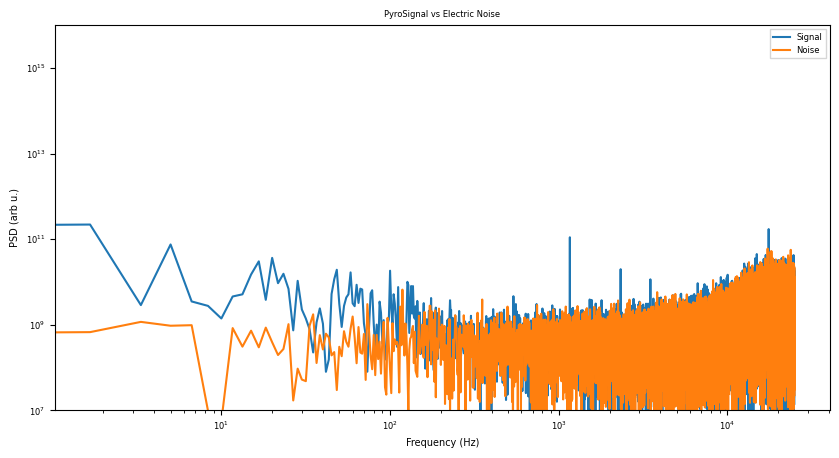

In [13]:

freq = np.fft.fftshift(np.fft.fftfreq(len(chargeYield[0,5000:35000]),20e-6))

spectrumCharge = np.fft.fftshift(np.fft.fft(chargeYield[:,5000:35000]-np.mean(chargeYield[:,5000:35000],axis=1)[:,None],axis=1),axes=1)
spectrumNoise = np.fft.fftshift(np.fft.fft(chargeYield[0,:]-np.mean(chargeYield[:,5000:35000],axis=1)[:,None],axis=1),axes=1)

spectrumEnergy = np.fft.fftshift(np.fft.fft(pulseEnergy[:,5000:35000]-np.mean(pulseEnergy[:,5000:35000],axis=1)[:,None],axis=1),axes=1)


plt.loglog(freq,np.abs(spectrumCharge[id,:])**2)
plt.loglog(freq,np.abs(spectrumCharge[0,:])**2)
plt.ylim([10e5,10e15])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (arb u.)')
plt.title('Charge Yield vs Electric Noise')
plt.legend(['Signal','Noise'])
plt.savefig(os.path.join(outPath,f"SpectrumChargeID{id}.pdf"))
plt.show()

plt.loglog(freq,np.abs(spectrumEnergy[id,:])**2)
plt.loglog(freq,np.abs(spectrumEnergy[0,:])**2)
plt.ylim([10e6,10e15])
plt.legend(['Signal','Noise'])

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (arb u.)')
plt.title('PyroSignal vs Electric Noise')
plt.savefig(os.path.join(outPath,f"SpectrumEnergyID{id}.pdf"))
plt.show()

[ 3223  4474  4477  4888  6051 14675 14897 14911 14918 14920 14925 14927
 14929 14934 14937 14940 14943 14948 14953 14957 14959 14963 14967 14969
 14971 14973 14976 14978 14980 14982 14987 14992 14994 14999 15001 15006
 15008 15013 15018 15020 15022 15024 15027 15029 15031 15033 15037 15041
 15043 15047 15052 15057 15060 15063 15066 15071 15073 15075 15080 15082
 15089 15103 15325 23949 25112 25523 25526 26777]


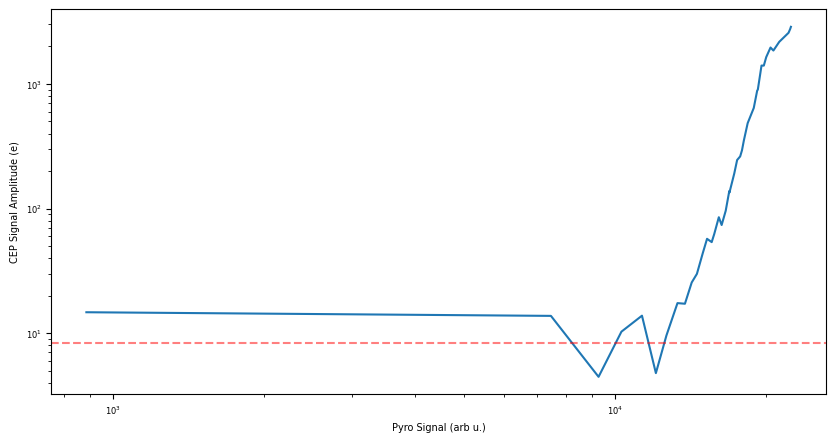

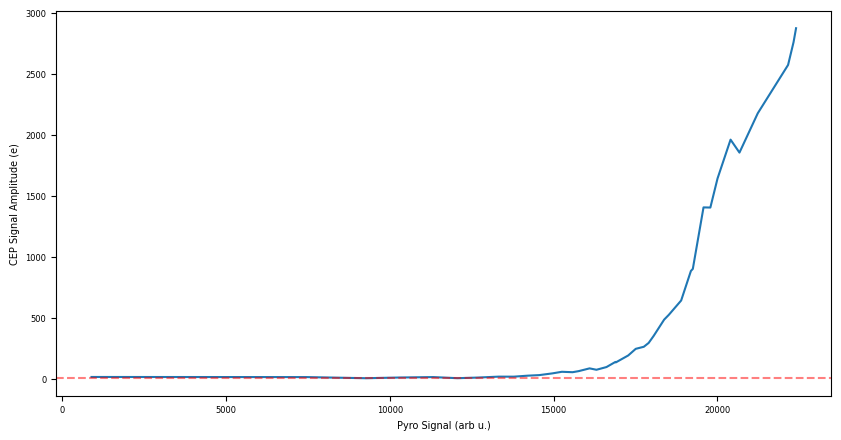

In [14]:
peaksTemp, _ = signal.find_peaks(np.abs(spectrumCharge[id,:])**2,height=1e12)
print(peaksTemp)
plt.loglog(np.mean(pulseEnergy[:-2,:],axis=1),np.abs(spectrumCharge[:-2,15006])/(0.5*len(freq)))
plt.xlabel('Pyro Signal (arb u.)')
plt.ylabel('CEP Signal Amplitude (e)')
plt.axhline(np.abs(spectrumCharge[-1,15006])/(0.5*len(freq)),color='red',linestyle='--',alpha=0.5)
plt.savefig(os.path.join(outPath,'CEPvsPyroLogLog.pdf'))
plt.show()

plt.plot(np.mean(pulseEnergy[:-2,:],axis=1),np.abs(spectrumCharge[:-2,15006])/(0.5*len(freq)))
plt.xlabel('Pyro Signal (arb u.)')
plt.ylabel('CEP Signal Amplitude (e)')
plt.axhline(np.abs(spectrumCharge[-1,15006])/(0.5*len(freq)),color='red',linestyle='--',alpha=0.5)
plt.savefig(os.path.join(outPath,'CEPvsPyroLinear.pdf'))
plt.show()


In [15]:
print(f"Electron Amplitude {np.abs(spectrumCharge[39,15006])/(0.5*len(freq))} e-")


Electron Amplitude 2978.0025046545325 e-


[ 4474 14302 14997 14999 15001 15003 15698 25526]


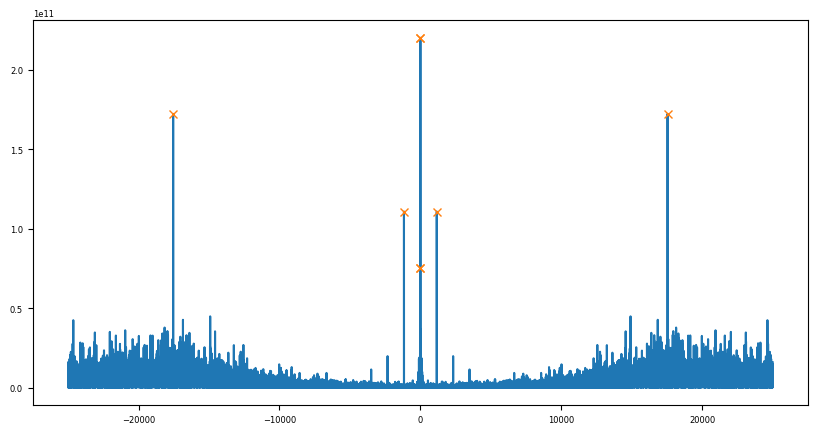

In [16]:
peaksTemp, _ = signal.find_peaks(np.abs(spectrumEnergy[id,:])**2,height=0.5e11)

plt.plot(freq,np.abs(spectrumEnergy[id,:])**2)
plt.plot(freq[peaksTemp],np.abs(spectrumEnergy[id,peaksTemp])**2,marker= 'x',linestyle='None')

print(peaksTemp)

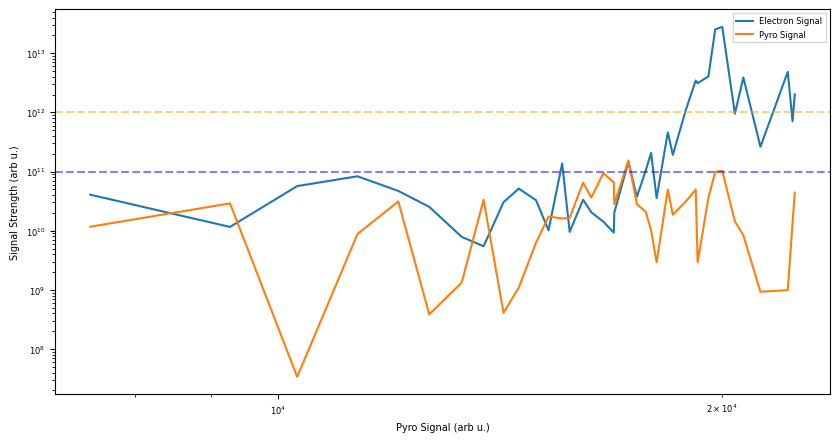

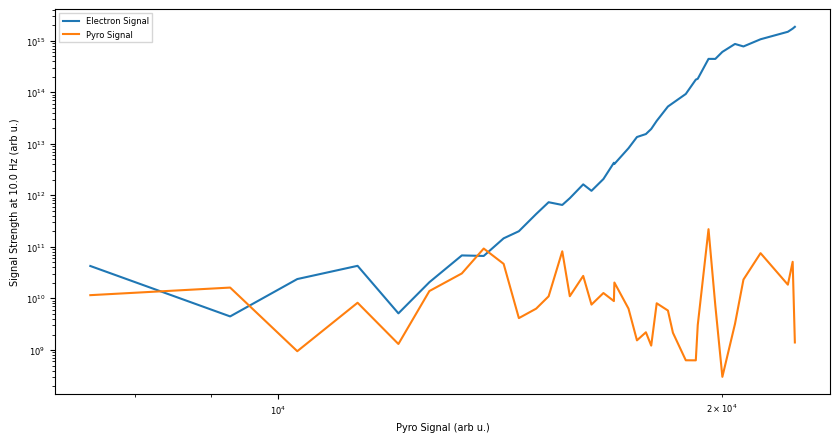

In [17]:
plt.loglog(np.mean(pulseEnergy[1:-2,:],axis=1),np.abs(spectrumCharge[1:-2,25525])**2)
plt.loglog(np.mean(pulseEnergy[1:-2,:],axis=1),np.abs(spectrumEnergy[1:-2,25525])**2)
plt.xlabel('Pyro Signal (arb u.)')
plt.ylabel(f"Signal Strength (arb u.)")
plt.legend(['Electron Signal','Pyro Signal'])
plt.axhline(1e11,color='blue',linestyle='--',alpha=0.5)
plt.axhline(1e12,color='orange',linestyle='--',alpha=0.5)

plt.savefig(os.path.join(outPath,'PyrovsElectronLogLogNoiseSupp.pdf'))
plt.show()


plt.loglog(np.mean(pulseEnergy[1:-2,:],axis=1),np.abs(spectrumCharge[1:-2,15006])**2)
plt.loglog(np.mean(pulseEnergy[1:-2,:],axis=1),np.abs(spectrumEnergy[1:-2,15006])**2)
plt.xlabel('Pyro Signal (arb u.)')
plt.ylabel(f"Signal Strength at {freq[15006]} Hz (arb u.)")
plt.legend(['Electron Signal','Pyro Signal'])
plt.savefig(os.path.join(outPath,'PyrovsElectronLogLogNoiseSuppCEP.pdf'))

plt.show()


/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/3643772702.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.semilogy(np.sqrt(np.mean(-pulseEnergy[1:-2,:],axis=1)),np.abs(spectrumCharge[1:-2,15006])**2)
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/3643772702.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.semilogy(np.sqrt(np.mean(-pulseEnergy[1:-2,:],axis=1)),np.abs(spectrumCharge[1:-2,25525])**2)
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/3643772702.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.semilogy(np.sqrt(np.mean(-pulseEnergy[1:-2,:],axis=1)),np.abs(spectrumEnergy[1:-2,25525])**2)


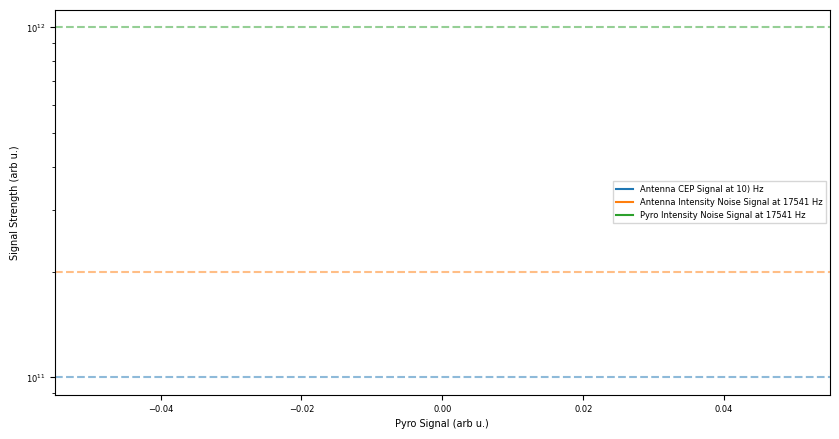

In [18]:


plt.semilogy(np.sqrt(np.mean(-pulseEnergy[1:-2,:],axis=1)),np.abs(spectrumCharge[1:-2,15006])**2)
plt.semilogy(np.sqrt(np.mean(-pulseEnergy[1:-2,:],axis=1)),np.abs(spectrumCharge[1:-2,25525])**2)

plt.semilogy(np.sqrt(np.mean(-pulseEnergy[1:-2,:],axis=1)),np.abs(spectrumEnergy[1:-2,25525])**2)

plt.axhline(1e11,color='#1f77b4',linestyle='--',alpha=0.5)
plt.axhline(2e11,color='#ff7f0e',linestyle='--',alpha=0.5)
plt.axhline(1e12,color='#2ca02c',linestyle='--',alpha=0.5)

plt.xlabel('Pyro Signal (arb u.)')
plt.ylabel(f"Signal Strength (arb u.)")
plt.legend([f"Antenna CEP Signal at {int(freq[15006])}) Hz" ,f"Antenna Intensity Noise Signal at {int(freq[25525])} Hz",f"Pyro Intensity Noise Signal at {int(freq[25525])} Hz"])
plt.savefig(os.path.join(outPath,'IntNoiseVSCEP.pdf'))

plt.show()


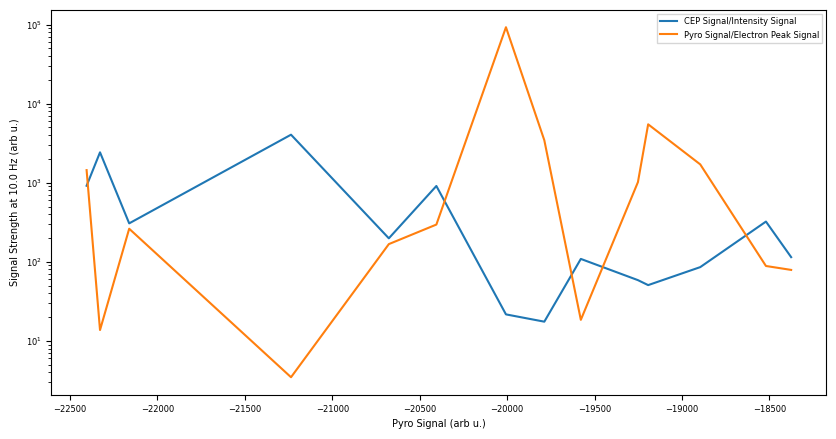

In [19]:
plt.semilogy(np.mean(-pulseEnergy[25:-2,:],axis=1),(np.abs(spectrumCharge[25:-2,15006])**2)/(np.abs(spectrumCharge[25:-2,25525])**2))
plt.semilogy(np.mean(-pulseEnergy[25:-2,:],axis=1),(np.abs(spectrumCharge[25:-2,25525])**2)/(np.abs(spectrumEnergy[25:-2,15006])**2))

plt.xlabel('Pyro Signal (arb u.)')
plt.ylabel(f"Signal Strength at {freq[15006]} Hz (arb u.)")
plt.legend([f"CEP Signal/Intensity Signal",f"Pyro Signal/Electron Peak Signal"])
plt.savefig('IntNoiseVSCEP.pdf')
plt.show()

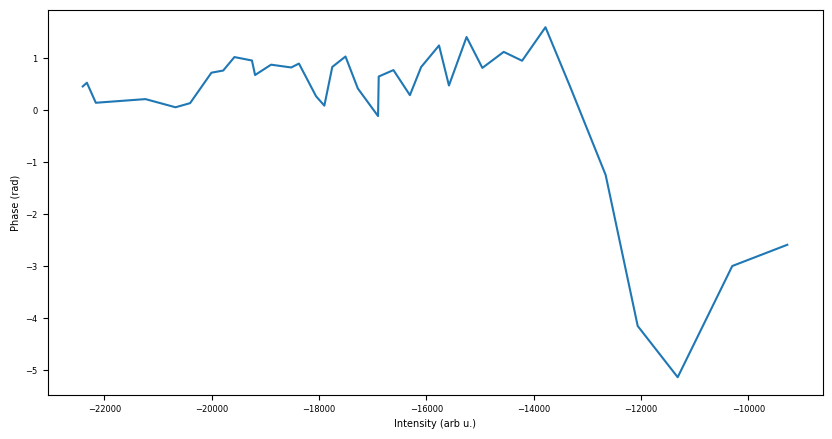

In [20]:
plt.plot(np.mean(-pulseEnergy[2:-2,:],axis=1),np.unwrap(np.angle(spectrumCharge[2:-2,15006])))
plt.xlabel('Intensity (arb u.)')
plt.ylabel('Phase (rad)')
plt.savefig(os.path.join(outPath,'CEPPhase.pdf'))
plt.show()

(-5e-13, 5e-13)

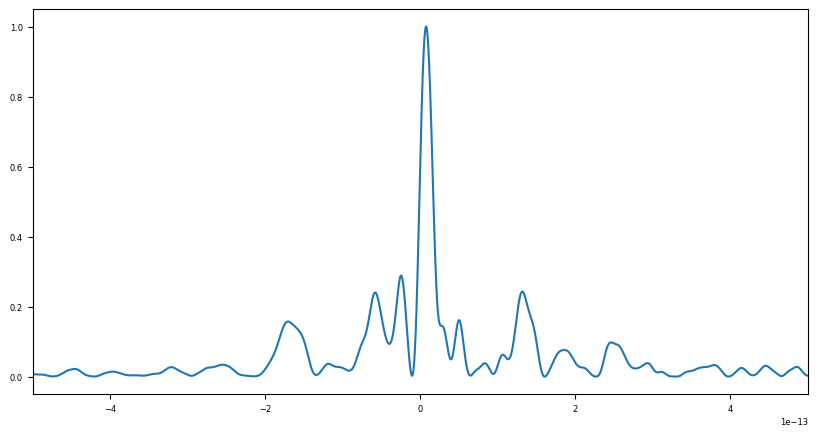

In [21]:
# Trying the fitting procedure
from scipy.signal import hilbert

timeAxis = np.genfromtxt('timeMIRMeasured04112022.csv',delimiter=',')
eField = hilbert(np.genfromtxt('efieldMIRMeasured04112022.csv',delimiter=','))
#timeAxis = np.genfromtxt('TimeMIR.csv',delimiter=',')
#eField = hilbert(np.genfromtxt('eFieldMIR.csv',delimiter=','))



eFieldNorm = np.exp(-1j*np.pi/2)*eField/np.max(np.abs(eField))

plt.plot(timeAxis,np.abs(eFieldNorm)**2)
plt.xlim([-0.5e-12,0.5e-12])



In [22]:
# Definition of the FN function
fnFCN = lambda E,fcrit: np.sign(np.real(E))* np.real(E)**2 * np.exp(-fcrit/(np.abs(np.real(E))))

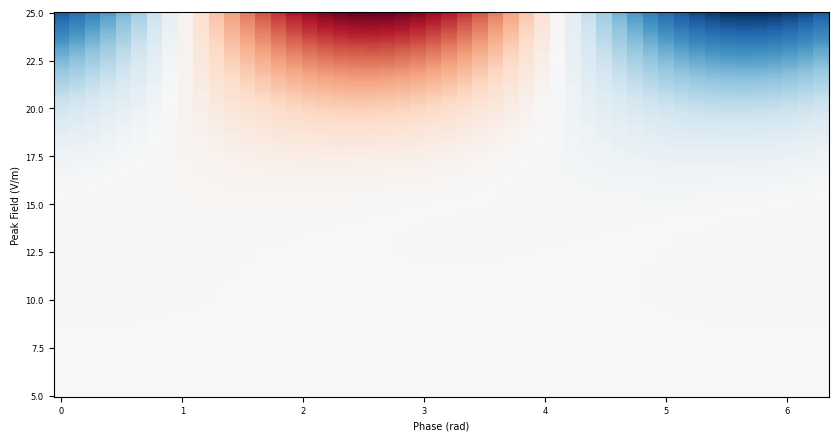

In [23]:

eList = np.linspace(5,25,200)
phaseList = np.linspace(0,2*np.pi,50)
cepMIREscan = np.zeros([len(eList),len(phaseList)])
FE = 1

for j in range(len(phaseList)):
    for i in range(len(eList)):
        cepMIREscan[i,j]=np.sum(fnFCN((-np.exp(1j*phaseList[j])*eFieldNorm*FE*eList[i]),78.7))



    
plt.pcolormesh(phaseList,eList,(cepMIREscan),rasterized=True,cmap='RdBu_r')
plt.xlabel('Phase (rad)')
plt.ylabel('Peak Field (V/m)')
plt.show()
#plt.ylabel('cep current (arb. u.)')


/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/538726535.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  out[i] = np.trapz(cepMIREscan[i,:]*np.exp(1j*phaseList),phaseList)


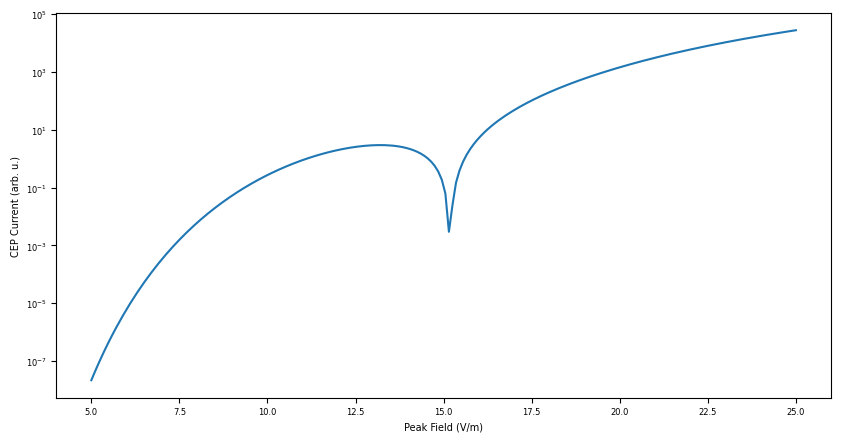

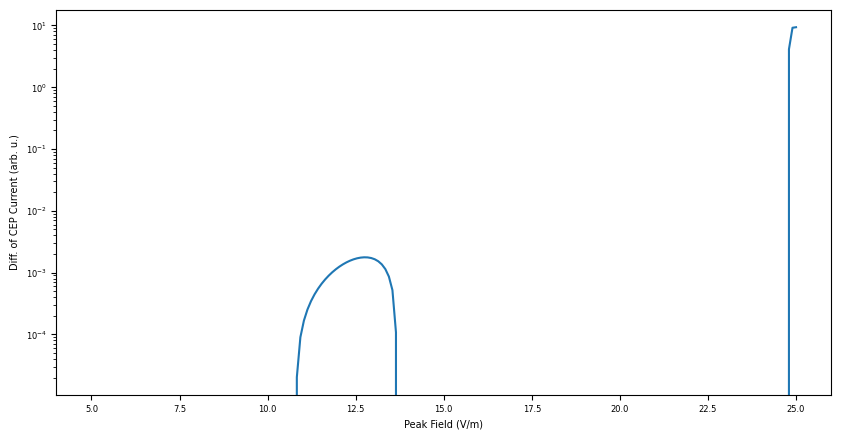

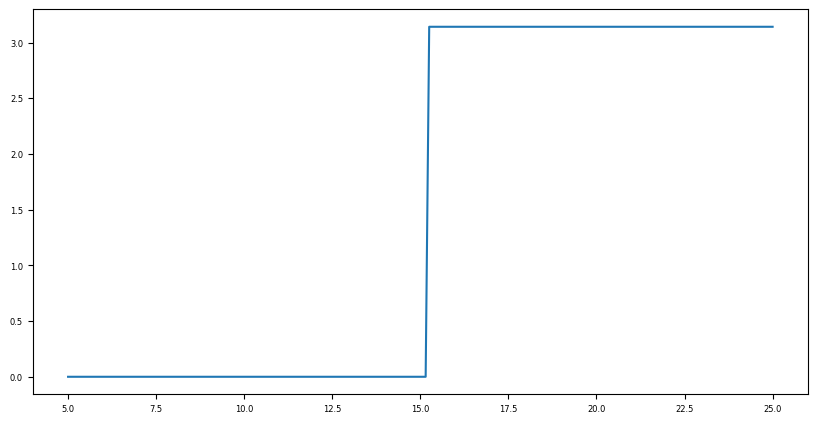

In [24]:
out=np.zeros(len(eList))

for i in range(len(eList)):
    out[i] = np.trapz(cepMIREscan[i,:]*np.exp(1j*phaseList),phaseList)

plt.semilogy(eList,np.abs(out)**2)
#plt.xlim([0,4])
#plt.ylim([-4,4])
plt.xlabel('Peak Field (V/m)')
plt.ylabel('CEP Current (arb. u.)')

plt.show()

plt.semilogy(eList,np.gradient(np.gradient(np.gradient(-np.abs(out)**2))))
#plt.xlim([0,4])
plt.xlabel('Peak Field (V/m)')
plt.ylabel('Diff. of CEP Current (arb. u.)')

plt.show()



plt.plot(eList,np.angle(out))
plt.show()

6.732966556163101


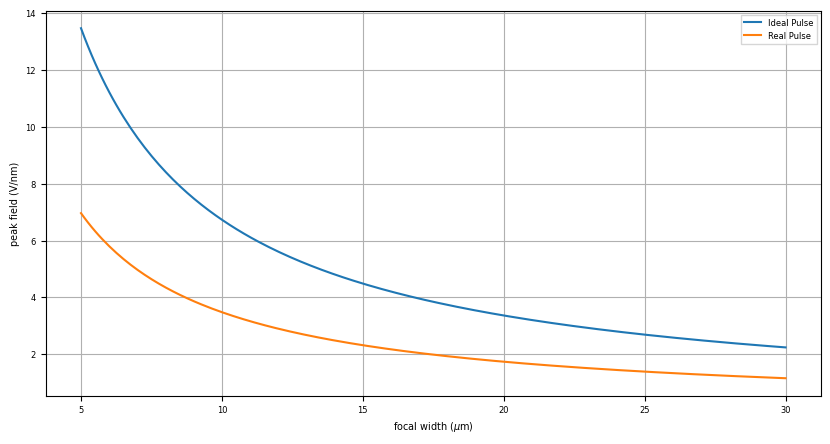

In [25]:
c=2.98e8
pulse = lambda t,tau,wvlgth,cep: np.exp(-2 * np.log(2) * (t)**2 / (tau*1e-15)**2)*np.exp(1j*(2*np.pi*t*c/(wvlgth*1e-9))+1j*cep)
peakField = lambda E,t,energy,d: np.sqrt(energy *8/(np.pi*d**2*scp.constants.epsilon_0*c*np.trapz(np.abs(E)**2,t)))
pEnergy= 80e-9

print(peakField(pulse(timeAxis,16,3000,0),timeAxis,pEnergy,10e-6)*1e-9)

widthList = np.linspace(5e-6,30e-6,200)

widthScan = np.zeros(len(widthList))
widthScan2 = np.zeros(len(widthList))


for i in range(len(widthList)):
    widthScan[i] = peakField(pulse(timeAxis,16,3000,0),timeAxis,pEnergy,widthList[i])
    widthScan2[i] = peakField(eFieldNorm,timeAxis,pEnergy,widthList[i])

plt.plot(widthList*1e6,widthScan*1e-9)
plt.plot(widthList*1e6,widthScan2*1e-9)
plt.legend(['Ideal Pulse','Real Pulse'])
plt.xlabel('focal width ($\mu$m)')
plt.ylabel('peak field (V/nm)')
plt.grid(True,which="both")
plt.show()

The beamsize is measured by knife edge, see Obsidian note 2022-12-13.

x = 19.9 um
y = 22 um

I'll take the average here.

There are 4 gold mirror bounces included and also measured.
We assume the calculated efficiency here of $0.98^4 = 0.92$


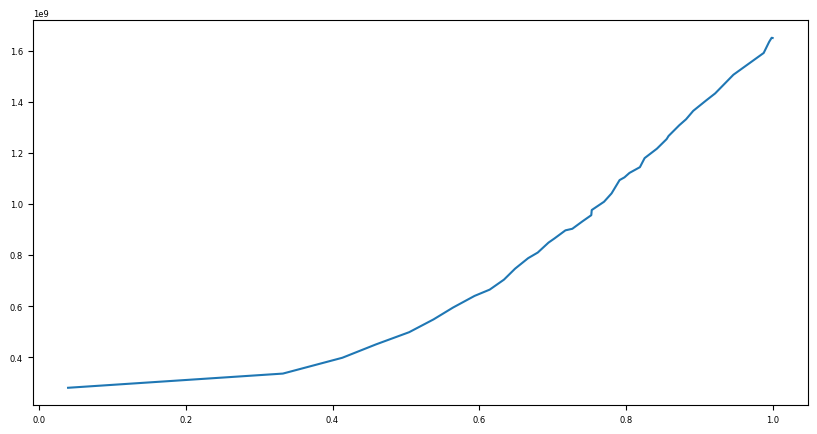

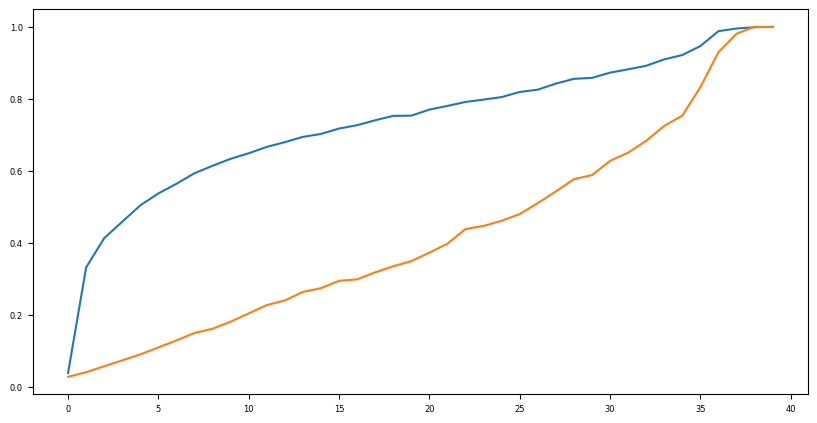

In [26]:
# Rescaling the pyro signal
maxPower = measDict['max Energy Post']
transportEff = 0.92
maxEnergy = transportEff*maxPower*1e-3/50e3 # in J
renormPyro= np.mean(np.abs(pulseEnergy[0:-1,:]),axis=1)/np.max(np.mean(np.abs(pulseEnergy[0:-1,:]),axis=1))
renormPyro2 = np.genfromtxt('renormPyro.csv',delimiter=',')

energyScale = renormPyro2*maxEnergy


fieldScale= peakField(eFieldNorm,timeAxis,energyScale,(0.5*(19.9+22))*1e-6)
plt.plot(np.mean(np.abs(pulseEnergy[0:-1,:]),axis=1)/np.max(np.mean(np.abs(pulseEnergy[0:-1,:]),axis=1)),fieldScale)
plt.show()

plt.plot(renormPyro)
plt.plot(renormPyro2)

246.46147242299318


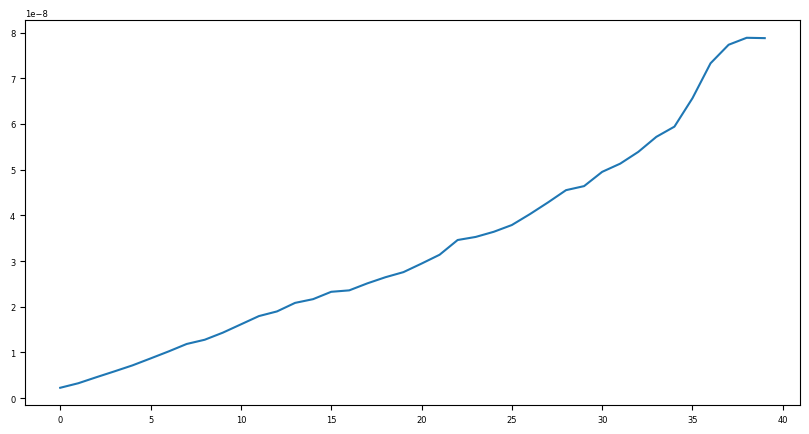

In [27]:
plt.plot(energyScale)

print(np.mean(np.abs(pulseEnergy[-1,:])))



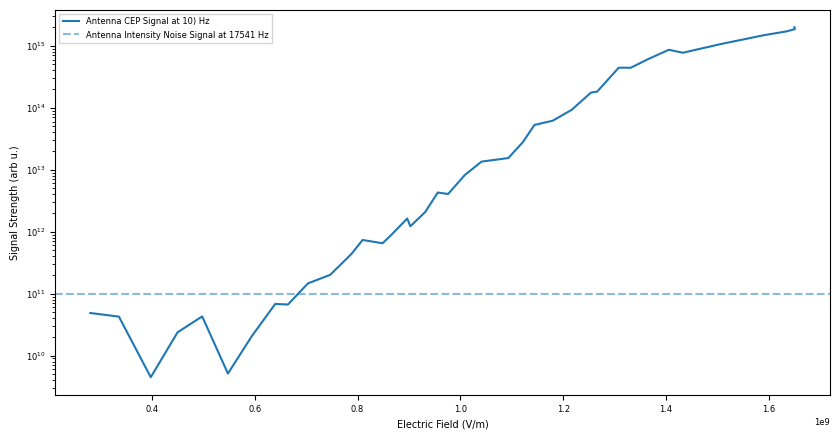

In [28]:

plt.semilogy(fieldScale,np.abs(spectrumCharge[0:-1,15006])**2)


plt.axhline(1e11,color='#1f77b4',linestyle='--',alpha=0.5)


plt.xlabel('Electric Field (V/m)')
plt.ylabel(f"Signal Strength (arb u.)")
plt.legend([f"Antenna CEP Signal at {int(freq[15006])}) Hz" ,f"Antenna Intensity Noise Signal at {int(freq[25525])} Hz",f"Pyro Intensity Noise Signal at {int(freq[25525])} Hz"])
plt.savefig(os.path.join(outPath,'IntNoiseVSCEP_FieldScale.pdf'))

plt.show()

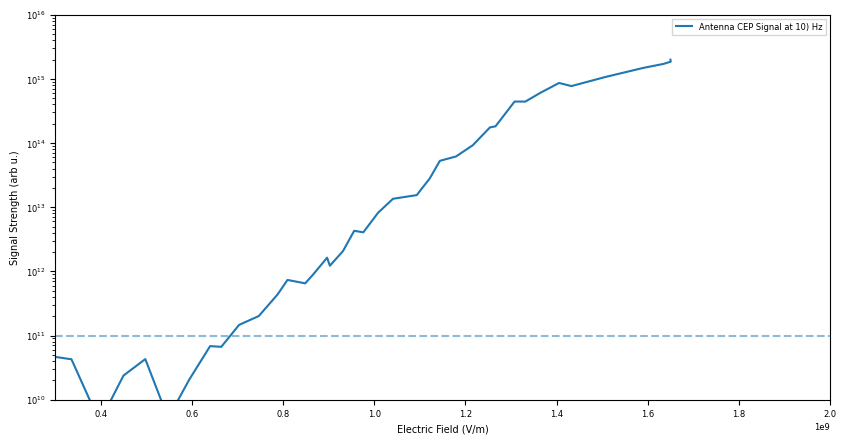

In [29]:

plt.semilogy(fieldScale,np.abs(spectrumCharge[0:-1,15006])**2)


plt.axhline(1e11,color='#1f77b4',linestyle='--',alpha=0.5)
#plt.axhline(2e11,color='#ff7f0e',linestyle='--',alpha=0.5)
#plt.axhline(1e12,color='#2ca02c',linestyle='--',alpha=0.5)

plt.xlabel('Electric Field (V/m)')
plt.ylabel(f"Signal Strength (arb u.)")
plt.legend([f"Antenna CEP Signal at {int(freq[15006])}) Hz" ])
plt.savefig(os.path.join(outPath,'IntNoiseVSCEP_FieldScale.pdf'))
plt.ylim([1e10,1e16])
plt.xlim([0.3e9,2e9])
plt.show()

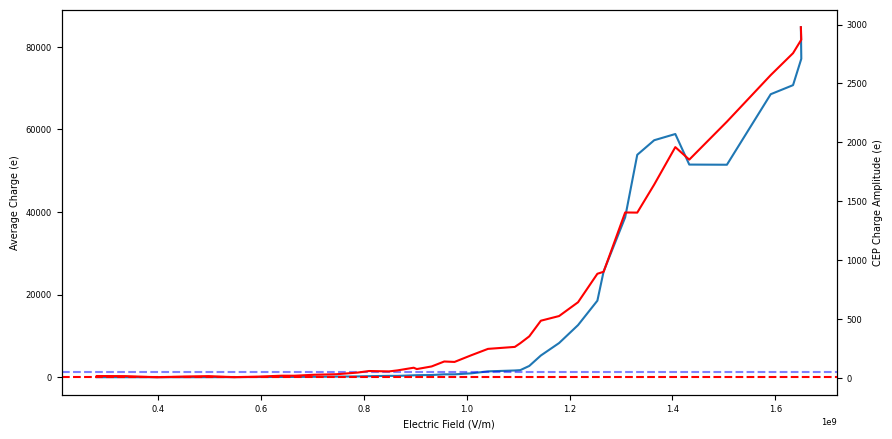

8.303426806253716


In [30]:
plt.plot(fieldScale,-np.mean(chargeYield[:-1,:],axis=1))

ax = plt.gca()
ax2 = ax.twinx()

ax2.plot(fieldScale,np.abs(spectrumCharge[:-1,15006])/(0.5*len(freq)),color='red')

ax.set_xlabel('Electric Field (V/m)')
ax.set_ylabel('Average Charge (e)')
ax2.set_ylabel('CEP Charge Amplitude (e)')

ax.axhline(np.std(chargeYield[-1,:]),color='blue',linestyle='--',alpha=0.5)
ax2.axhline(np.abs(spectrumCharge[-1,15006])/(0.5*len(freq)),color='red',linestyle='--')

plt.savefig(os.path.join(outPath,'TotalChargeVsCEPCharge.pdf'))
plt.show()

print(np.abs(spectrumCharge[-1,15006])/(0.5*len(freq)))

# Fitting Data to Model

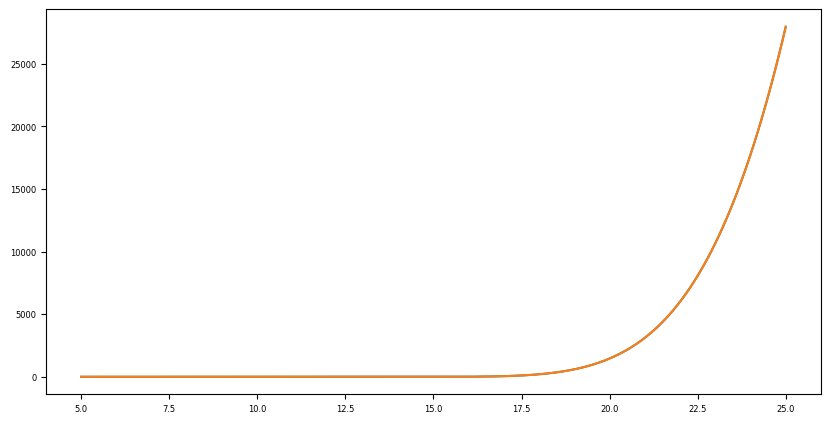

In [31]:
cepFit = scp.interpolate.interp1d(eList,(np.abs(out)**2),fill_value="extrapolate")

plt.plot(eList,np.abs(out)**2)
plt.plot(eList,cepFit(eList))
plt.show()

[7.96556985e+00 6.10828134e+14]


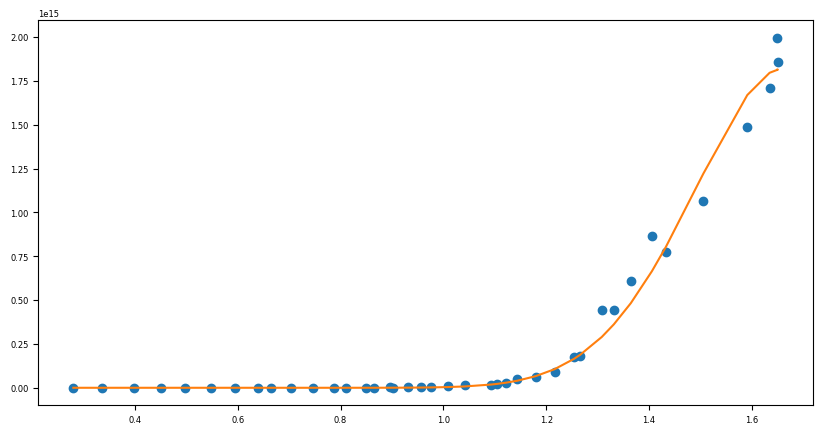

In [32]:
def cepFitFCN(x,FE,amp):
    return amp*cepFit(x*FE)

popt, pcov = scp.optimize.curve_fit(cepFitFCN,fieldScale[0:]*1e-9,np.abs(spectrumCharge[0:-1,15006])**2,p0=[6,8e16])

plt.plot(fieldScale[0:]*1e-9,np.abs(spectrumCharge[0:-1,15006])**2,marker='o',linestyle='None')
plt.plot(fieldScale*1e-9,cepFitFCN(fieldScale*1e-9,*popt))
print(popt)

1647.6624979302533
15000.0
[  14.72636226   13.76936788    4.46598513   10.28510269   13.81991498
    4.78154334    9.58268586   17.4343118    17.23124975   25.52927881
   29.91950939   43.92415323   57.18830465   53.80051548   62.5425631
   85.21024795   73.77651779   95.98613427  138.08138003  134.37910992
  190.9358592   245.2847073   262.07652821  293.49383071  351.6290081
  484.58631572  524.19479136  641.40141062  883.47970799  900.29860368
 1404.16410435 1402.94170716 1641.28013864 1959.38145496 1853.12796048
 2175.55435023 2571.29992617 2757.47757747 2872.25894529 2978.00250465]


/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/1570273400.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq)))


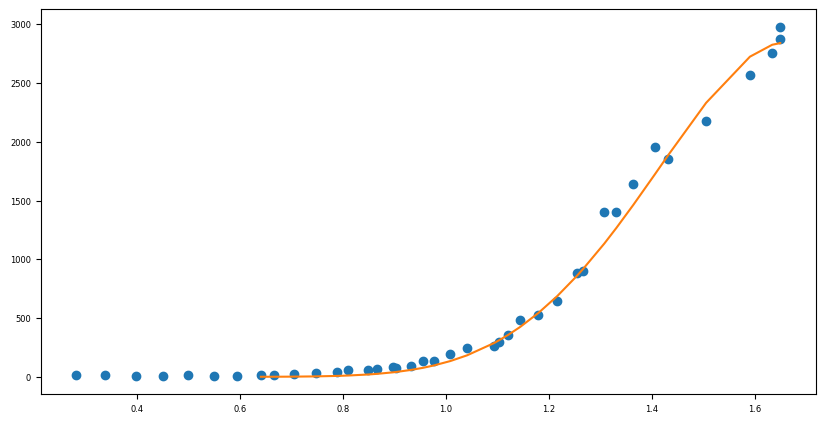

In [33]:

plt.plot(fieldScale[0:]*1e-9,np.abs(spectrumCharge[0:-1,15006])/(0.5*len(freq)),marker='o',linestyle='None')
plt.plot(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq)))

print(np.sqrt(popt[1])/(0.5*len(freq)))
print(0.5*len(freq))

print(np.abs(spectrumCharge[0:-1,15006])/(0.5*len(freq)))

/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/2340145138.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.semilogy(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq))+20)
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/2340145138.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([0.25,0.5,0.75,1,1.5,2,4])
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/2340145138.py:23: RuntimeWarning: divide by zero encountered in divide
  g = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*4.7)/(7.2*x)


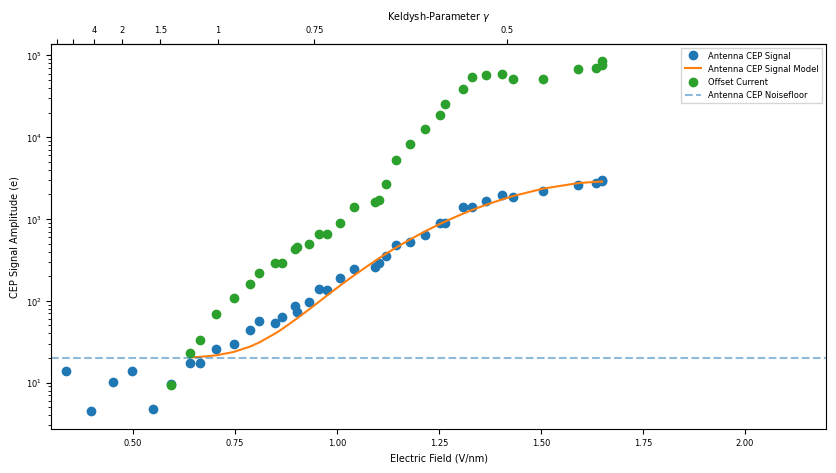

[7.96556985e+00 6.10828134e+14]


In [34]:


plt.semilogy(fieldScale[0:]*1e-9,np.abs(spectrumCharge[0:-1,15006])/(0.5*len(freq)),marker='o',linestyle='None')

plt.semilogy(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq))+20)

plt.semilogy(fieldScale[0:]*1e-9,np.mean(-chargeYield[:-1,:],axis=1),marker='o',linestyle='None')

#plt.semilogy(fieldScale*1e-9,(np.gradient(np.gradient(cepFitFCN(fieldScale*1e-9,*popt)))),color='#ff7f0e')


plt.axhline(2e1,color='#1f77b4',linestyle='--',alpha=0.5)
#plt.axhline(2e11,color='#ff7f0e',linestyle='--',alpha=0.5)

plt.xlabel('Electric Field (V/nm)')
plt.ylabel(f"CEP Signal Amplitude (e)")
plt.legend([f"Antenna CEP Signal" ,f"Antenna CEP Signal Model",f"Offset Current",f"Antenna CEP Noisefloor",f"Antenna Offset Noisefloor"])
#plt.ylim([1e7,1e16])
plt.xlim([0.3,2.2])

# Define function and its inverse
wvlgth =2.7e-6
phi = 4.7 
f = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*4.7)/(7.2*x) # 7.2 is the FE scaling Factor
g = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*4.7)/(7.2*x)

ax = plt.gca()
ax2 = ax.secondary_xaxis("top", functions=(f,g))
ax2.set_xlabel("Keldysh-Parameter $\gamma$")
ax2.set_xticklabels([0.25,0.5,0.75,1,1.5,2,4])


plt.savefig(os.path.join(outPath,'SCalingVsModelFit.pdf'))
plt.savefig(os.path.join(outPath,'SCalingVsModelFit.png'),dpi=600)
plt.show()

print(popt)

/Users/felix/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/818972367.py:14: RuntimeWarning: invalid value encountered in sqrt
  plt.semilogy(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq)))


[8.20929050e+00 9.48457557e+05 1.00000000e+01]
[  8.         147.25472575   7.65951525  13.73765834]


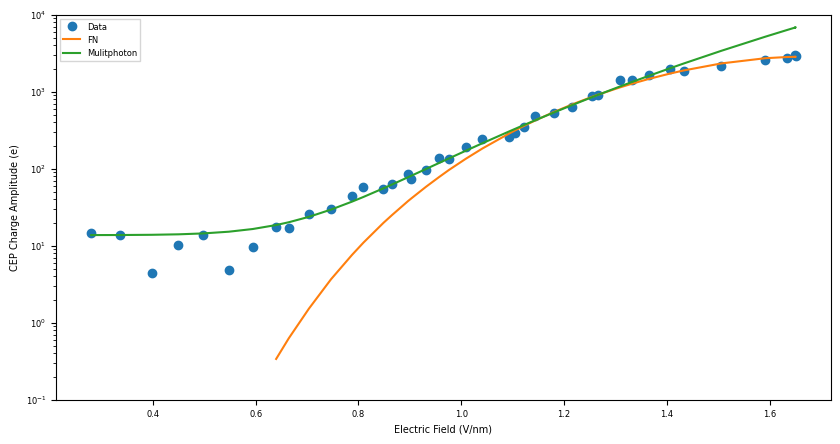

In [35]:
def cepFitFCN2(x,FE,amp,c):
    return (amp*(cepFit(x*FE))**2)

def mPhoton (x,FE,amp,n,c):
    return amp*(x)**n +c


popt2, pcov = scp.optimize.curve_fit(cepFitFCN2,fieldScale[:]*1e-9,(np.abs(spectrumCharge[0:-1,15006])/(0.5*len(freq)))**2,p0=[7,1000,10])

popt3, pcov = scp.optimize.curve_fit(mPhoton,fieldScale[0:30]*1e-9,(np.abs(spectrumCharge[0:30,15006])/(0.5*len(freq))),p0=[8,1700,10,8])


plt.semilogy(fieldScale[0:]*1e-9,np.abs(spectrumCharge[0:-1,15006])/(0.5*len(freq)),marker='o',linestyle='None')
plt.semilogy(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq)))
plt.semilogy(fieldScale*1e-9,(mPhoton(fieldScale*1e-9,*popt3)))
#plt.semilogy(fieldScale*1e-9,(cepFitFCN2(fieldScale*1e-9,*popt2))+(mPhoton(fieldScale*1e-9,*popt3)))
plt.xlabel('Electric Field (V/nm)')
plt.ylabel('CEP Charge Amplitude (e)')
plt.legend(['Data','FN','Mulitphoton','FN+Mulitphoton'])
plt.ylim([1e-1,1e4])
plt.savefig(os.path.join(outPath,'CompoundFitCEPChargeVsField.pdf'))

print(popt2)
print(popt3)

/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/4014120221.py:10: RuntimeWarning: invalid value encountered in sqrt
  ax.semilogy(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq)))
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/4014120221.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([0.25,0.5,0.75,1,1.5,2,4])
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/4014120221.py:34: RuntimeWarning: divide by zero encountered in divide
  g = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*5.1)/(7.2*x)


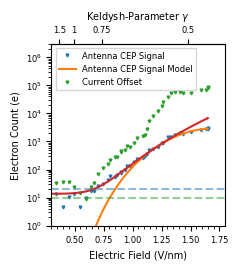

[7.96556985e+00 6.10828134e+14]


In [36]:
fieldFudge=1/8
preFactor = 5e14




fig,ax = plt.subplots(1,1,figsize=(cm*5.7,cm*6),sharex=True)

ax.semilogy(fieldScale*1e-9,np.abs(spectrumCharge[:-1,15006])/(0.5*len(freq)),linestyle= 'None',marker='v',markersize=2)
ax.semilogy(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq)))
ax.semilogy(fieldScale*1e-9,np.abs(np.mean(chargeYield[:-1,:],axis=1)),linestyle= 'None',marker='v',markersize=2)
ax.semilogy(fieldScale*1e-9,(mPhoton(fieldScale*1e-9,*popt3)))



#plt.semilogy(fieldScale,np.abs(spectrumCharge[1:-2,25525])**2)


ax.axhline(2e1,color='#1f77b4',linestyle='--',alpha=0.5)
#plt.axhline(2e11,color='#ff7f0e',linestyle='--',alpha=0.5)
ax.axhline(1e1,color='#2ca02c',linestyle='--',alpha=0.5)

ax.set_xlabel('Electric Field (V/nm)')
ax.set_ylabel(f"Electron Count (e)")
ax.legend([f"Antenna CEP Signal" ,f"Antenna CEP Signal Model",f"Current Offset"])
ax.set_ylim([1e0,3e6])
ax.set_xlim([0.3,1.8])
ax.minorticks_on()
#ax.grid(which='major', linestyle='-', linewidth='0.5', color='black',alpha=0.2)
# Define function and its inverse
wvlgth =2.7e-6
phi = 4.7 
f = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*5.1)/(7.2*x) # 7.2 is the FE scaling Factor
g = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*5.1)/(7.2*x)

ax = plt.gca()
ax2 = ax.secondary_xaxis("top", functions=(f,g))
ax2.set_xlabel("Keldysh-Parameter $\gamma$")
ax2.set_xticklabels([0.25,0.5,0.75,1,1.5,2,4])

plt.savefig(os.path.join(outPath,'SCalingVsModelFitV2.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(outPath,'SCalingVsModelFitV2.png'),dpi=600)
plt.show()

print(popt)

/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/4053800224.py:4: RuntimeWarning: invalid value encountered in sqrt
  ax.semilogy(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq)))
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/4053800224.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([0.25,0.5,0.75,1,1.5,2,4])
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/4053800224.py:28: RuntimeWarning: divide by zero encountered in divide
  g = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*5.1)/(7.2*x)


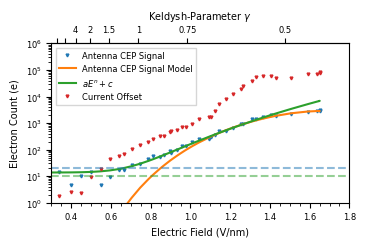

[7.96556985e+00 6.10828134e+14]
1647.0
[  8.         147.25472575   7.65951525  13.73765834]
2978.0025046545325
-84779.22675113201


In [37]:




fig,ax = plt.subplots(1,1,figsize=(cm*9,cm*6),sharex=True,constrained_layout=True)

ax.semilogy(fieldScale*1e-9,np.abs(spectrumCharge[:-1,15006])/(0.5*len(freq)),linestyle= 'None',marker='v',markersize=2)
ax.semilogy(fieldScale*1e-9,np.sqrt(cepFitFCN(fieldScale*1e-9,*popt))/(0.5*len(freq)))
ax.semilogy(fieldScale*1e-9,(mPhoton(fieldScale*1e-9,*popt3)))

ax.semilogy(fieldScale*1e-9,np.abs((np.mean(chargeYield[:-1,:],axis=1)-(np.mean(chargeYield[-1,:])))),linestyle= 'None',marker='v',markersize=2)




#plt.semilogy(fieldScale,np.abs(spectrumCharge[1:-2,25525])**2)
ax.axhline(2e1,color='#1f77b4',linestyle='--',alpha=0.5)
#plt.axhline(2e11,color='#ff7f0e',linestyle='--',alpha=0.5)
ax.axhline(1e1,color='#2ca02c',linestyle='--',alpha=0.5)

ax.set_xlabel('Electric Field (V/nm)')
ax.set_ylabel(f"Electron Count (e)")
ax.legend([f"Antenna CEP Signal" ,f"Antenna CEP Signal Model",f"$a E^n+c$",f"Current Offset"])
ax.set_ylim([1e0,1e6])
ax.set_xlim([0.3,1.8])
ax.minorticks_on()
#ax.grid(which='major', linestyle='-', linewidth='0.5', color='black',alpha=0.2)
# Define function and its inverse
wvlgth =2.7e-6
phi = 4.7 
f = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*5.1)/(7.2*x) # 7.2 is the FE scaling Factor
g = lambda x: (2*np.pi/wvlgth)*np.sqrt(2*511e3*5.1)/(7.2*x)

ax = fig.gca()
ax2 = ax.secondary_xaxis("top", functions=(f,g))
ax2.set_xlabel("Keldysh-Parameter $\gamma$")
ax2.set_xticklabels([0.25,0.5,0.75,1,1.5,2,4])

fig.savefig(os.path.join(outPath,'SCalingVsModelFitV2.pdf'),bbox_inches='tight')
fig.savefig(os.path.join(outPath,'SCalingVsModelFitV2.png'),dpi=600)
plt.show()

print(popt)
print(np.sqrt(popt[1])//(0.5*len(freq)))

print(popt3)

print(np.abs(spectrumCharge[-2,15006])/(0.5*len(freq)))
print(np.mean(chargeYield[-2,:]))

34.383613417188386
33.75899302321117


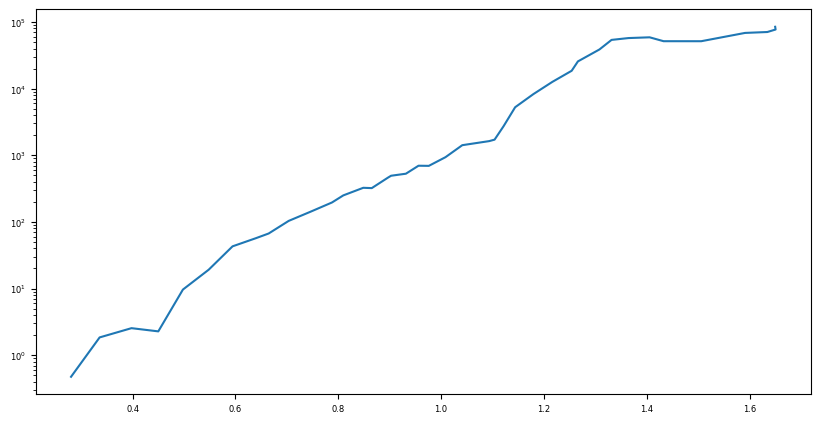

In [38]:
plt.semilogy(fieldScale*1e-9,np.abs((np.mean(chargeYield[:-1,:],axis=1)-(np.mean(chargeYield[-1,:])))))

print(np.mean(np.mean(chargeYield[0:4,:],axis=1)))

print(np.mean(chargeYield[-1,:]))

/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/1278400819.py:6: RuntimeWarning: invalid value encountered in power
  ax[0].loglog(freq,1200/(freq)**(3/4),linestyle='--',color='k',alpha=0.5)
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/1278400819.py:6: RuntimeWarning: divide by zero encountered in divide
  ax[0].loglog(freq,1200/(freq)**(3/4),linestyle='--',color='k',alpha=0.5)
/var/folders/x1/2f1g9h354t98pmp3q9lvty100000gn/T/ipykernel_54477/1278400819.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


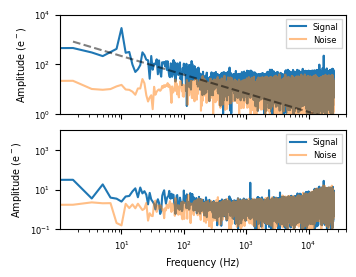

In [39]:


fig,ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [1,1]},figsize=(cm*9,cm*7),sharex=True,constrained_layout=True)


ax[0].loglog(freq,np.abs(spectrumCharge[id,:])/(0.5*len(freq)))
ax[0].loglog(freq,np.abs(spectrumCharge[0,:])/(0.5*len(freq)),alpha=0.5)
ax[0].loglog(freq,1200/(freq)**(3/4),linestyle='--',color='k',alpha=0.5)

ax[0].set_ylim([1e0,1e4])
ax[0].set_ylabel('Amplitude (e$^-$)')
ax[0].minorticks_on()
ax[0].legend(['Signal','Noise'])

ax[1].loglog(freq,np.abs(spectrumEnergy[id,:])/(0.5*len(freq)))
ax[1].loglog(freq,np.abs(spectrumEnergy[0,:])/(0.5*len(freq)),alpha=0.5)
ax[1].set_ylim([1e-1,1e4])
ax[1].minorticks_on()

ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude (e$^-$)')
ax[1].legend(['Signal','Noise'])
fig.tight_layout()
plt.savefig(os.path.join(outPath,f"SpectrumEnergyPaperID{id}.png"),dpi=300)
plt.savefig(os.path.join(outPath,f"SpectrumEnergyPaperID{id}.pdf"))


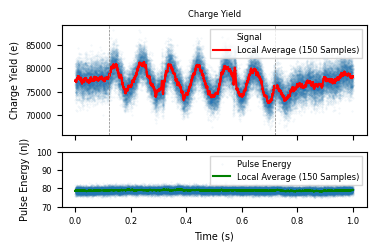

In [40]:


# Plotting the charge yield
from scipy.ndimage import uniform_filter1d
avgCount = 150

testOut = uniform_filter1d(chargeYield[id,:], size=avgCount)
testOut2 = uniform_filter1d(maxEnergy*(-pulseEnergy[id,:])/np.mean(-pulseEnergy[id,:]), size=avgCount)



fig,ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [2,1]},figsize=(cm*10,cm*6),sharex=True)

ax[0].scatter(time,-chargeYield[id,:],s=0.1,alpha=0.1,rasterized=True)
ax[0].plot(time,-testOut,color='red',alpha=1)
#ax[0].set_ylim([70000,100000])
ax[0].axvline(0.12,linestyle='dashed',color='grey',linewidth = 0.5,alpha=1)
ax[0].axvline(0.72,linestyle='dashed',color='grey',linewidth = 0.5,alpha=1)

ax[0].set_ylabel('Charge Yield (e)')
ax[0].set_title('Charge Yield')
ax[0].legend(['Signal',f"Local Average ({avgCount} Samples)"])

ax[1].scatter(time,1e9*maxEnergy*(-pulseEnergy[id,:])/np.mean(-pulseEnergy[id,:]),s=0.1,alpha=0.1,rasterized=True)
ax[1].plot(time,1e9*testOut2,color='green',alpha=1)
ax[1].set_ylabel('Pulse Energy (nJ)')
ax[1].set_ylim([70,100])

ax[1].set_xlabel('Time (s)')
ax[1].legend(['Pulse Energy',f"Local Average ({avgCount} Samples)"])
fig.savefig(os.path.join(outPath,f"ChargeYieldVsEnergy{id}.pdf"),dpi=600)
fig.savefig(os.path.join(outPath,f"ChargeYieldVsEnergy{id}.png"),dpi=300)

plt.show()